# Assignment 2

In [1]:
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
import math
from scipy import signal
import ncc
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Part 1: Face Detection in a Scaled Representation

### Question 2

In [48]:
def make_gaussian_pyramid(image, scale, minsize):
    # initial image and dimensions
    if np.array(image).ndim == 3:
        sigma = (1/(2*scale),1/(2*scale),0)
    else:
        sigma = 1/(2*scale)
    gauss_img = Image.fromarray(gaussian_filter(np.array(image), sigma=sigma))
    pyramid = [gauss_img]
    # while both h,w are larger than minsize
    while gauss_img.height >= minsize and gauss_img.width >= minsize:
        # resize image w/ scale using bicubic interpolation 
        dim = (int(gauss_img.width*scale), int(gauss_img.height*scale))
        gauss_img = gauss_img.resize(dim, Image.BICUBIC)
        # apply smoothing filter and add to pyramid
        gauss_img = Image.fromarray(gaussian_filter(np.array(gauss_img), sigma=sigma))
        pyramid.append(gauss_img)
    return pyramid

### Question 3

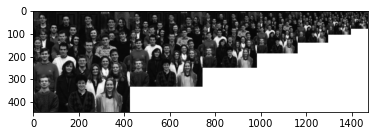

In [32]:
def show_gaussian_pyramid(pyramid):
    # set height and width of pyramid image
    height = pyramid[0].height
    widths = []
    for img in pyramid:
        widths.append(img.width)
    collage = Image.new("RGB", (sum(widths), height), (255,255,255))
    
    for idx,img in enumerate(pyramid):
        # offset by sum of prev widths
        offset_x = sum(widths[:idx])
        # paste imgs to pyramid img
        collage.paste(img, (offset_x, 0))
    
    # show the pyramid image 
    plt.imshow(collage)
    plt.show()

image = Image.open("faces/students.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
show_gaussian_pyramid(pyramid)

### Question 4

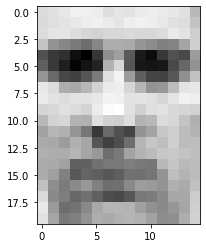

In [33]:
# create a template with new width, scaling height equivalently
def create_template(width):
    t = Image.open("faces/template.jpg")
    scale = width/t.width
    template = t.resize((int(t.width*scale), int(t.height*scale)), Image.BICUBIC)
    return template

def find_template(pyramid, template, threshold):
    face_points = []
    for idx,img in enumerate(pyramid):
        # normalized corss correlation on image and face-template
        ncc_array = ncc.normxcorr2D(img, template)
        # iterate through pixles
        for x in range(img.width):
            for y in range(img.height):
                # check its value against the threshold
                if ncc_array[y][x] > threshold:
                    # append to face_points if above given threshold
                    face_points.append((x/(0.75**idx), y/(0.75**idx)))
    return face_points

def draw_bounding_boxes(image,face_points):
    # convert image to RGB for red box
    image = image.convert("RGB")
    # make 20x25 rectangles around face points
    for p in face_points:
        draw = ImageDraw.Draw(image)
        x1 = p[0]-20
        x2 = p[0]+20
        y1 = p[1]-25
        y2 = p[1]+25
        draw.line((x1,y1,x1,y2),fill="red",width=2)
        draw.line((x2,y1,x2,y2),fill="red",width=2)
        draw.line((x1,y1,x2,y1),fill="red",width=2)
        draw.line((x1,y2,x2,y2),fill="red",width=2)
        del draw
    # show image
    plt.imshow(image)
    plt.show()
    
template15 = create_template(15)
plt.imshow(template15, cmap="gray")
plt.show()

### Question 5

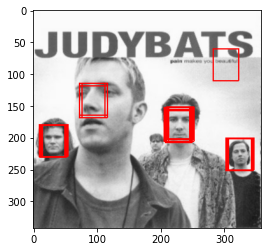

Error rate: 1/1
Recall rate: 4/5 = 0.8


In [34]:
image = Image.open("faces/judybats.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.6)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 1/1")
print("Recall rate: 4/5 = 0.8")

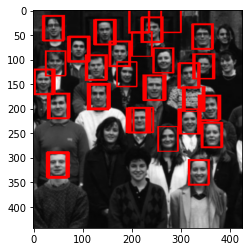

Error rate: 3/4
Recall rate: 23/27 = 0.85


In [20]:
image = Image.open("faces/students.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.55)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 4/4")
print("Recall rate: 23/27 = 0.85")

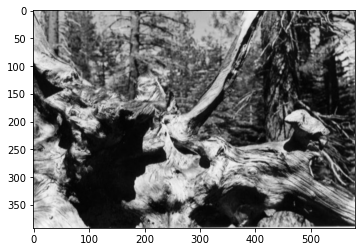

Error rate: 0/0
Recall rate: 0/0


In [19]:
image = Image.open("faces/tree.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.7)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 0/0")
print("Recall rate: 0/0")

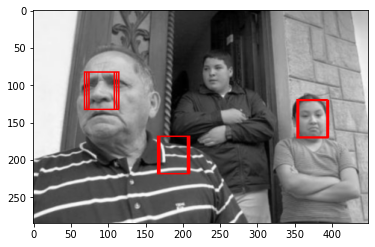

Error rate: 1/1
Recall rate: 2/3 = 0.66


In [15]:
image = Image.open("faces/family.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.59)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 1/1")
print("Recall rate: 2/3 = 0.66")

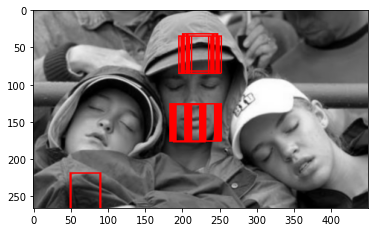

Error rate: 3/3
Recall rate: 0/3 = 0


In [16]:
image = Image.open("faces/fans.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.6)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 3/3")
print("Recall rate: 0/3 = 0")

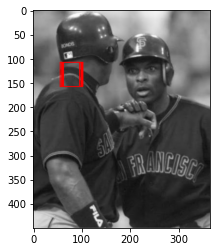

Error rate: 2/1
Recall rate: 0/1 = 0


In [17]:
image = Image.open("faces/sports.jpg")
pyramid = make_gaussian_pyramid(image, 0.75, 100)
face_points = find_template(pyramid, template15, 0.55)
draw_bounding_boxes(pyramid[0], face_points)
print("Error rate: 1/1")
print("Recall rate: 0/1 = 0")

### Question 6
As you can see, the NCC method performed very poorly on the last two images. This is because the faces in the picture do not match the given template well. 

In the image of fans, all three faces have their eyes closed. This results in a lower correlation with the template face, since the template's eyes are dark and the fan's eyelids are light. Additionally, the two faces on the left and right are not exactly vertical. Since we only adjusted for scale, the NCC algorithm can recognize faces of different sizes, but not when they are rotated. Accounting for rotations while using template matching is infeasible in practice, due to the number of different degrees an object can be rotated (i.e. 360).

In the last image, the baseball player is wearing a batting helmet that obstructs his face. More importantly, however, NCC introduces racial biases. The template face has lighter skin, while the baseball player has darker skin. Due to the darker color of the baseball player's skin, his face does not correlate well with the template, meaning the NCC algorithm is not able to recognize his face at all.

## Part 2: Image Blending

### Question 2

In [50]:
def make_laplacian_pyramid(image, scale, minsize):
    # make Gaussian pyramid
    gauss_pyramid = make_gaussian_pyramid(image, scale, minsize)
    # form Laplacian for first image
    first_laplace = np.array(image,dtype=np.float32) - np.array(gauss_pyramid[0],dtype=np.float32)
    laplacian_pyramid = [first_laplace]
    
    # for each image in Gaussian pyramid except for highest level
    for i in range(len(gauss_pyramid)-1):
        if i > 0:
            curr_level = gauss_pyramid[i]
            # resize previous level to current level size
            prev_level_resized = gauss_pyramid[i-1].resize(curr_level.size, Image.BICUBIC)
            # subtract to form laplacian image
            laplace_img = np.array(prev_level_resized,dtype=np.float32) - np.array(curr_level,dtype=np.float32)
            laplacian_pyramid.append(laplace_img)
    
    # highest level is same as Gaussian pyramid
    laplacian_pyramid.append(np.array(gauss_pyramid[-1],dtype=np.float32))
    return laplacian_pyramid

### Question 3

Laplacian pyramid of violet.jpg:


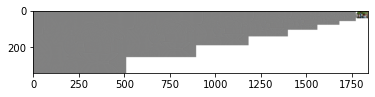

Laplacian pyramid of orchid.jpg:


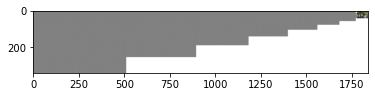

In [51]:
def show_laplacian_pyramid(pyramid):
    # set height and width of pyramid image
    height = pyramid[0].shape[0]
    widths = []
    for img in pyramid:
        widths.append(img.shape[1])
    # create new image for displaying pyramid
    collage = Image.new("RGB", (sum(widths), height), (255,255,255))
    for idx,img in enumerate(pyramid):
        # if not highest level of pyramid
        if idx != len(pyramid)-1:
            # offset levels from [-128,128] to [0,255]
            img = Image.fromarray(np.array(img+128,dtype=np.uint8))
        else:
            img = Image.fromarray(np.array(img,dtype=np.uint8))
        # offset by sum of prev widths
        offset_x = sum(widths[:idx])
        # paste imgs to pyramid img
        collage.paste(img, (offset_x, 0))
    # show the pyramid image 
    plt.imshow(collage)
    plt.show()

print("Laplacian pyramid of violet.jpg:")
img = Image.open("objects/violet.jpg")
violet_pyramid = make_laplacian_pyramid(img, 0.75, 50)
show_laplacian_pyramid(violet_pyramid)

print("Laplacian pyramid of orchid.jpg:")
img = Image.open("objects/orchid.jpg")
orchid_pyramid = make_laplacian_pyramid(img, 0.75, 50)
show_laplacian_pyramid(orchid_pyramid)

### Question 4

Gaussian pyramid of violet.jpg:


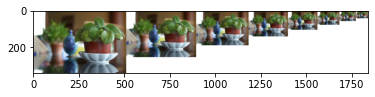

Gaussian pyramid of orchid.jpg:


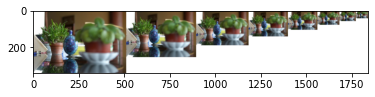

Reconstructed Gaussian pyramid of violet.jpg


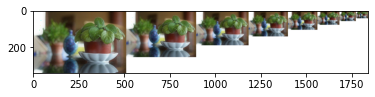

Reconstructed Gaussian pyramid of orchid.jpg


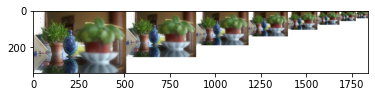

In [52]:
def reconstruct_gaussian_from_laplacian_pyramid(lpyramid):
    # initalize Gaussian pyramid w/ highest level of Laplacian pyramid
    curr_level = Image.fromarray(lpyramid[-1].astype(np.uint8))
    next_level = lpyramid[-2]
    gpyramid = [curr_level]
    # upsample current level to size of next level
    h, w, c = next_level.shape
    upsampled_gauss = curr_level.resize((w,h), Image.BICUBIC)
    # add upsampled Gaussian and next level of Laplace to reconstruct next Gaussian
    reconstructed_gauss = Image.fromarray(np.array(np.array(upsampled_gauss) + next_level, dtype=np.uint8))
    gpyramid.insert(0,reconstructed_gauss)
    
    # bottom-up recursive reconstruction
    for idx,img in reversed(list(enumerate(lpyramid))):
        if idx < len(lpyramid)-1 and idx-1 >= 0:
            curr_level = gpyramid[0]
            next_level = lpyramid[idx-1]
            h, w, c = next_level.shape
            upsampled_gauss = curr_level.resize((w,h), Image.BICUBIC)
            reconstructed_gauss = np.array(np.array(upsampled_gauss) + next_level, dtype=np.uint8)
            gpyramid.insert(0,Image.fromarray(reconstructed_gauss))
    return gpyramid


print("Gaussian pyramid of violet.jpg:")
img = Image.open("objects/violet.jpg")
pyramid = make_gaussian_pyramid(img, 0.75, 50)
show_gaussian_pyramid(pyramid)

print("Gaussian pyramid of orchid.jpg:")
img = Image.open("objects/orchid.jpg")
pyramid = make_gaussian_pyramid(img, 0.75, 50)
show_gaussian_pyramid(pyramid)

print("Reconstructed Gaussian pyramid of violet.jpg")
reconstructed_violet = reconstruct_gaussian_from_laplacian_pyramid(violet_pyramid)
show_gaussian_pyramid(reconstructed_violet)

print("Reconstructed Gaussian pyramid of orchid.jpg")
reconstructed_orchid = reconstruct_gaussian_from_laplacian_pyramid(orchid_pyramid)
show_gaussian_pyramid(reconstructed_orchid)

### Question 5

Gaussian pyramid of orchid_mask.bmp:


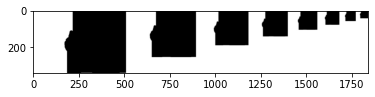

In [53]:
print("Gaussian pyramid of orchid_mask.bmp:")
img = Image.open("objects/orchid_mask.bmp")
orchid_mask_pyramid = make_gaussian_pyramid(img, 0.75, 50)
show_gaussian_pyramid(orchid_mask_pyramid)

### Question 6

Composed Laplacian pyramid:


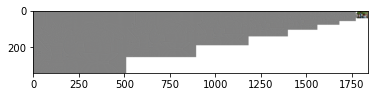

Reconstructed Gaussian pyramid from Laplacian pyramids:


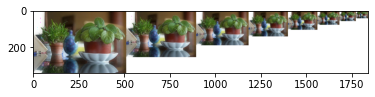

In [55]:
def compose_lpyramids(lapA, lapB, gaussianM):
    composed_lpyramid = []
    if len(lapA) == len(lapB) == len(gaussianM):
        for i in range(len(lapA)):
            # Split images into RGB channels
            lapAR, lapAG, lapAB = lapA[i][:, :, 0], lapA[i][:, :, 1], lapA[i][:, :, 2]
            lapBR, lapBG, lapBB = lapB[i][:, :, 0], lapB[i][:, :, 1], lapB[i][:, :, 2]
            mask = np.array(gaussianM[i], dtype=np.float32)
            
            composed_channels = []
            # Synthesize empty image, same size as original
            empty = Image.new('L',(lapA[i].shape[1],lapA[i].shape[0]))
            # Compose Laplacian for each channel separately
            for channelA, channelB in [(lapAR,lapBR), (lapAG,lapBG), (lapAB,lapBB)]:
                compLaplacian = channelA*(mask/255) + channelB*(1-(mask/255))
                composed_channels.append(compLaplacian)
            # Merge channels and add to pyramid
            composed_lpyramid.append(np.dstack(composed_channels))
    else:
        # print lengths for debugging
        print(len(lapA), len(lapB), len(gaussianM))
    return composed_lpyramid

composed_violet_orchid = compose_lpyramids(orchid_pyramid, violet_pyramid, orchid_mask_pyramid)
print("Composed Laplacian pyramid:")
show_laplacian_pyramid(composed_violet_orchid)
blended_violet_orchid = reconstruct_gaussian_from_laplacian_pyramid(composed_violet_orchid)
print("Reconstructed Gaussian pyramid from Laplacian pyramids:")
show_gaussian_pyramid(blended_violet_orchid)

### Question 7

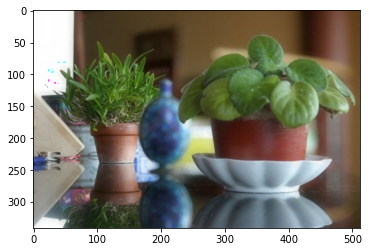

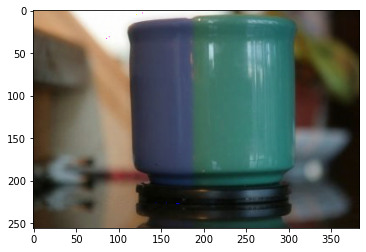

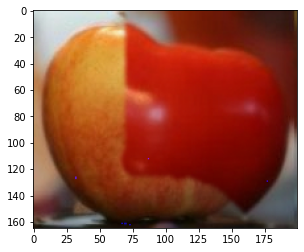

In [57]:
# main function for blending images
def blend_imgs(imgA_path, imgB_path, mask_path, scale, minsize):
    # open images
    imgA = Image.open(imgA_path)
    imgB = Image.open(imgB_path)
    mask = Image.open(mask_path)
    # form Laplacian pyramids from imgs, Gaussian pyramid from mask
    imgA_lpyramid = make_laplacian_pyramid(imgA, scale, minsize)
    imgB_lpyramid = make_laplacian_pyramid(imgB, scale, minsize)
    mask_gpyramid = make_gaussian_pyramid(mask, scale, minsize)
    # compose Laplacian pyramids and use to reconstruct Gaussian pyramid
    composed_lpyramid = compose_lpyramids(imgA_lpyramid, imgB_lpyramid, mask_gpyramid)
    blended_gpyramid = reconstruct_gaussian_from_laplacian_pyramid(composed_lpyramid)
    plt.imshow(blended_gpyramid[0])
    plt.show()

blend_imgs("objects/orchid.jpg", "objects/violet.jpg", "objects/orchid_mask.bmp", 0.75, 100)
blend_imgs("objects/blue_cup.jpg", "objects/green_cup.jpg", "objects/cup_mask.bmp", 0.75, 100)
blend_imgs("objects/apple.jpg", "objects/tomato.jpg", "objects/tomato_mask.bmp", 0.75, 100)